In [1]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import mdtraj as md
import pickle
import glob
import sys
import os
import openbabel as ob

*run *.sh files under hippos-env env*

**Re-index XRD residue id**

In [2]:
# xrd residue index start from 0; increasing residue index from 1, do not restart indexing for new chains
xrd_files = glob.glob("xrd/*pdb")
for input_pdb in xrd_files:
    # only reindex and save for protein
    output_pdb = input_pdb.split('.pdb')[0] + '_pro.pdb'
    residue_flag = -1
    new_residue_index = 0
    with open(input_pdb, 'r') as infile, open(output_pdb, 'w') as outfile:
        for line in infile:            
            if line.startswith(("ATOM")):                
                residue_index = int(line[22:26].strip())
                # To keep all the structures have the same residue index, all the monomers are truncated into aa 1-88
                if residue_index > 87:
                    continue
                    
                if residue_index != residue_flag:
                    new_residue_index += 1
                residue_flag = residue_index
                
                line = line[:22] + f"{new_residue_index:4d}" + line[26:]
                outfile.write(line)
            elif not line.startswith(("HETATM")):                
                outfile.write(line)
    # save for 2 ligands
    output_pdb1 = input_pdb.split('.pdb')[0] + '_lig1.pdb'
    output_pdb2 = input_pdb.split('.pdb')[0] + '_lig2.pdb'
    residue_flag = -999
    with open(input_pdb, 'r') as infile, open(output_pdb1, 'w') as outfile1, open(output_pdb2, 'w') as outfile2:
        for line in infile:  
            if line.startswith(("HETATM")):                
                residue_name = line[17:20].strip()
                #remove water and ions
                if residue_name not in ['CA', 'HOH']:
                    residue_index = int(line[22:26].strip())
                    if (residue_flag == -999) or (residue_flag==residue_index):
                        outfile1.write(line)
                        residue_flag = residue_index
                    else:
                        outfile2.write(line)    

**Determine pocket residues**

In [2]:
def check_missing_heavy_atoms(pdb_file):
    # Initialize Open Babel conversion
    ob_conversion = ob.OBConversion()
    ob_conversion.SetInFormat('pdb')

    # Create an OBMol object and read the molecule from the PDB file
    proteinmol = ob.OBMol()
    if not ob_conversion.ReadFile(proteinmol, pdb_file):
        print("Error: Could not read the PDB file.")
        return

    # Predefined heavy atom sets for all 20 standard amino acids
    residue_heavy_atoms = {
        "ALA": {"N", "CA", "C", "O", "CB"},
        "GLY": {"N", "CA", "C", "O"},
        "SER": {"N", "CA", "C", "O", "CB", "OG"},
        "THR": {"N", "CA", "C", "O", "CB", "OG1", "CG2"},
        "CYS": {"N", "CA", "C", "O", "CB", "SG"},
        "VAL": {"N", "CA", "C", "O", "CB", "CG1", "CG2"},
        "ILE": {"N", "CA", "C", "O", "CB", "CG1", "CG2", "CD1"},
        "LEU": {"N", "CA", "C", "O", "CB", "CG", "CD1", "CD2"},
        "ASP": {"N", "CA", "C", "O", "CB", "CG", "OD1", "OD2"},
        "GLU": {"N", "CA", "C", "O", "CB", "CG", "CD", "OE1", "OE2"},
        "ASN": {"N", "CA", "C", "O", "CB", "CG", "OD1", "ND2"},
        "GLN": {"N", "CA", "C", "O", "CB", "CG", "CD", "OE1", "NE2"},
        "MET": {"N", "CA", "C", "O", "CB", "CG", "SD", "CE"},
        "PHE": {"N", "CA", "C", "O", "CB", "CG", "CD1", "CD2", "CE1", "CE2", "CZ"},
        "TYR": {"N", "CA", "C", "O", "CB", "CG", "CD1", "CD2", "CE1", "CE2", "CZ", "OH"},
        "TRP": {"N", "CA", "C", "O", "CB", "CG", "CD1", "CD2", "NE1", "CE2", "CE3", "CZ2", "CZ3", "CH2"},
        "HIS": {"N", "CA", "C", "O", "CB", "CG", "ND1", "CD2", "CE1", "NE2"},
        "LYS": {"N", "CA", "C", "O", "CB", "CG", "CD", "CE", "NZ"},
        "ARG": {"N", "CA", "C", "O", "CB", "CG", "CD", "NE", "CZ", "NH1", "NH2"},
        "PRO": {"N", "CA", "C", "O", "CB", "CG", "CD"},
    }

    # Iterate over residues and check for missing heavy atoms
    for residue in ob.OBResidueIter(proteinmol):
        res_name = residue.GetName()
        res_num = residue.GetNum()

        # Get heavy atoms in the current residue
        present_heavy_atoms = set()
        for atom in ob.OBResidueAtomIter(residue):
            atom_name = residue.GetAtomID(atom).strip()
            if atom.GetAtomicNum() > 1:  # Only heavy atoms (non-H)
                present_heavy_atoms.add(atom_name)

        # Compare with the expected heavy atoms
        expected_atoms = residue_heavy_atoms.get(res_name, set())
        missing_atoms = expected_atoms - present_heavy_atoms

        # Report missing atoms
        if missing_atoms:
            print(f"Residue {res_name} {res_num} is missing heavy atoms: {', '.join(missing_atoms)}")

In [14]:
check_missing_heavy_atoms('xrd/5345_pro.pdb')

/home/xgu/miniconda3/envs/openmm/lib/python3.10/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is xrd/5345_pro.pdb)



In [15]:
check_missing_heavy_atoms('xrd/5369_pro.pdb')

Residue LYS 25 is missing heavy atoms: CG, CE, NZ, CD
Residue GLU 134 is missing heavy atoms: CG, OE1, OE2, CD


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is xrd/5369_pro.pdb)



In [16]:
ct_off = 0.5 #unit: nm
pro_files = glob.glob("xrd/*_pro.pdb")
for input_pdb in pro_files:
    traj_pro = md.load(input_pdb)
    lig_files = glob.glob(input_pdb.split('_pro.pdb')[0] + "_lig*.pdb")
    for lig_file in lig_files:
        traj_lig = md.load(lig_file)
        res_name=[]
        res_num=[]
        res_name_perm=[]
        res_num_perm=[]        
        for residue in traj_pro.topology.residues:        
            for atom in residue.atoms:
                dist_list = np.linalg.norm(traj_lig.xyz[0,:,:] - traj_pro.xyz[0,atom.index,:], axis=1)
                if np.min(dist_list) < ct_off:
                    if ('69' in input_pdb) and ((residue.resSeq ==134) or (residue.resSeq ==25)):  # skip residues missing key heavy atoms
                        print("missing heavy atoms at:", lig_file[:-4], residue.resSeq)                    
                        break
                    
                    res_name.append(f'{residue.name}{residue.resSeq}')
                    res_num.append(f'{residue.resSeq}')
                    # also save the pocket info for permutated pocket
                    if residue.resSeq > 88:
                        perm_id = int(residue.resSeq -88)
                    else:
                        perm_id = int(residue.resSeq +88)
                    res_name_perm.append(f'{residue.name}{perm_id}')
                    res_num_perm.append(f'{perm_id}')   
                   
                    break  
        with open(f'{lig_file[:-4]}.pk.txt', 'w') as outfile:
            outfile.write('residue_name    '+' '.join(res_name)+'\n')
            outfile.write('residue_number  '+' '.join(res_num)+'\n')
        with open(f'{lig_file[:-4]}.pk_perm.txt', 'w') as outfile:
            outfile.write('residue_name    '+' '.join(res_name_perm)+'\n')
            outfile.write('residue_number  '+' '.join(res_num_perm)+'\n')

missing heavy atoms at: xrd/5369_lig1 134


**Convert .pdb to .mol2 format**

In [4]:
def pdb_to_mol2(input_pdb, output_mol2):
    ob_conversion = ob.OBConversion()
    ob_conversion.SetInAndOutFormats("pdb", "mol2")
    #ob_conversion.AddOption("h", ob.OBConversion.OUTOPTIONS)
    
    mol = ob.OBMol()
    if not ob_conversion.ReadFile(mol, input_pdb):
        print("Error reading PDB file.")
        return

    if not ob_conversion.WriteFile(mol, output_mol2):
        print("Error writing MOL2 file.")
        return
    
    print(f"Conversion complete. Saved to {output_mol2}")

In [5]:
pro_files = glob.glob("xrd/*_pro.pdb")
for input_pdb in pro_files:
    output_mol2 = f'{input_pdb[:-4]}'+ '.mol2'
    pdb_to_mol2(input_pdb, output_mol2)
    
    lig_files = glob.glob(input_pdb.split('_pro.pdb')[0] + "_lig*.pdb")
    for lig_file in lig_files:
        output_mol2 = f'{lig_file[:-4]}'+ '.mol2'
        pdb_to_mol2(lig_file, output_mol2)        

Conversion complete. Saved to xrd/5345_pro.mol2
Conversion complete. Saved to xrd/5345_lig1.mol2
Conversion complete. Saved to xrd/5345_lig2.mol2
Conversion complete. Saved to xrd/5369_pro.mol2
Conversion complete. Saved to xrd/5369_lig1.mol2
Conversion complete. Saved to xrd/5369_lig2.mol2


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is xrd/5345_pro.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is xrd/5369_pro.pdb)



**cross-similarity for xrd**

In [17]:
# generate input configure files
pro_files = glob.glob("xrd/*_pro.mol2")
for input_pdb in pro_files:    
    lig_files = glob.glob(input_pdb.split('_pro.mol2')[0] + "_lig*.mol2")
    for lig_file in lig_files:
        with open(f'{lig_file[:-5]}.pk.txt', 'r') as infile, open(f"genref-{lig_file.split('/')[-1][:-5]}.txt", 'w') as outfile:
            for line in infile:
                outfile.write(line)
            outfile.write(f'proteins    {input_pdb}\n')
            outfile.write(f'ligands     {lig_file}\n')
            outfile.write(f"outfile     ref-results-{lig_file.split('/')[-1][:-5]}.txt\n")

In [18]:
bash = 'genref.sh'
config_files = glob.glob("genref*txt")
with open(bash, 'w') as outfile:
    for config_file in config_files:
        outfile.write(f"hippos-genref {config_file}\n")

In [19]:
def tanimoto_coefficient(bitstring1, bitstring2):
    """
    Compute the Tanimoto coefficient between two bitstrings.
    Args:
        bitstring1 (str): The first bitstring.
        bitstring2 (str): The second bitstring.
    Returns:
        float: The Tanimoto coefficient.
    """
    assert len(bitstring1) == len(bitstring2), "Bitstrings must be of the same length."
    
    # Convert bitstrings to integers for computation
    A = sum(int(b) for b in bitstring1)
    B = sum(int(b) for b in bitstring2)
    A_and_B = sum(int(b1) & int(b2) for b1, b2 in zip(bitstring1, bitstring2))
    
    return A_and_B / (A + B - A_and_B)

def mcconnaughey_coefficient(bitstring1, bitstring2):
    """
    Compute the mcconnaughey coefficient between two bitstrings.
    Args:
        bitstring1 (str): The first bitstring.
        bitstring2 (str): The second bitstring.
    Returns:
        float: The mcconnaughey coefficient.
    """
    assert len(bitstring1) == len(bitstring2), "Bitstrings must be of the same length."
    
    # Convert bitstrings to integers for computation
    A = sum(int(b) for b in bitstring1)
    B = sum(int(b) for b in bitstring2)
    A_and_B = sum(int(b1) & int(b2) for b1, b2 in zip(bitstring1, bitstring2))
    if (A == 0) or (B == 0):
        coe = -1
    else:
        coe = (A_and_B*(A+B)-A*B) / (A*B)
    return coe

In [22]:
# generate input configure files
wkdir = os.getcwd()
if not os.path.exists(f"{wkdir}/cross_xrd"):
    os.mkdir(f"{wkdir}/cross_xrd")
    
pk_files = glob.glob(f"{wkdir}/xrd/*pk*")
pro_files = glob.glob(f"{wkdir}/xrd/*_pro.mol2")
for pk_file in pk_files:
    for input_pdb in pro_files:    
        lig_files = glob.glob(input_pdb.split('_pro.mol2')[0] + "_lig*.mol2")
        for lig_file in lig_files:    
            with open(pk_file, 'r') as infile, open(f"{wkdir}/cross_xrd/config-{lig_file.split('/')[-1][:-5]}.struc.{pk_file.split('/')[-1]}", 'w') as outfile:
                for line in infile:
                    outfile.write(line)
                outfile.write(f'proteins    {input_pdb}\n')
                outfile.write(f'ligands     {lig_file}\n')
                outfile.write(f"outfile     {wkdir}/cross_xrd/results-{lig_file.split('/')[-1][:-5]}.struc.{pk_file.split('/')[-1]}\n")

In [23]:
bash = 'cross.sh'
config_files = glob.glob(f"{wkdir}/cross_xrd/config-*txt")
with open(bash, 'w') as outfile:
    for config_file in config_files:
        outfile.write(f"hippos-genref {config_file}\n")

In [24]:
plif_lists = ['5345_lig1', '5345_lig2', '5369_lig1', '5369_lig2']
tc_matrix = np.zeros((4,4))
Mcc_matrix = np.zeros((4,4))

for r_id, ref in enumerate(plif_lists):   
    with open(f'ref-results-{ref}.txt', 'r') as infile:
        for line in infile:
            if line.startswith(('full_bitstring')):
                ref_plif = line.split()[-1]
    for c_id, cross in enumerate(plif_lists):
        tc = []
        Mcc =[]
        for pk in ['pk', 'pk_perm']:
            file_path = f'cross_xrd/results-{cross}.struc.{ref}.{pk}.txt'
            if os.path.exists(file_path):  
                with open(file_path, 'r') as infile:
                    for line in infile:
                        if line.startswith(('full_bitstring')):
                            cross_plif = line.split()[-1]
                            tc.append(tanimoto_coefficient(ref_plif,cross_plif))
                            Mcc.append(mcconnaughey_coefficient(ref_plif,cross_plif))
            else:
                tc.append(-999)
                Mcc.append(-999)
        if max(tc) > 0 :
            tc_matrix[r_id][c_id] = max(tc)
            Mcc_matrix[r_id][c_id] = max(Mcc)
        else:
            tc_matrix[r_id][c_id] = np.nan
            Mcc_matrix[r_id][c_id] = np.nan                       

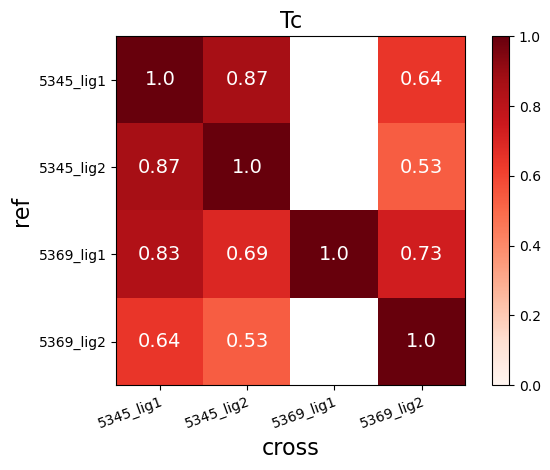

In [25]:
fig, ax = plt.subplots()
im = ax.imshow(tc_matrix, cmap='Reds',vmin=0, vmax=1)
plt.colorbar(im, ax=ax)


# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(plif_lists)), labels=plif_lists,
              rotation=20, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(plif_lists)), labels=plif_lists)

# Loop over data dimensions and create text annotations.
for i in range(len(plif_lists)):
    for j in range(len(plif_lists)):
        text = ax.text(j, i, round(tc_matrix[i][j],2),
                       ha="center", va="center", color="w",fontsize=14)

ax.set_title("Tc",fontsize=16)
plt.xlabel('cross',fontsize=16)
plt.ylabel('ref',fontsize=16)
fig.tight_layout()
plt.savefig(f"cross_Tc.png",dpi=300)

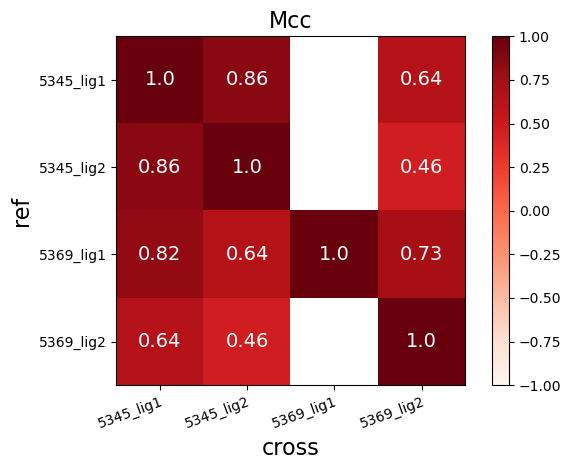

In [26]:
fig, ax = plt.subplots()
im = ax.imshow(Mcc_matrix, cmap='Reds',vmin=-1, vmax=1)
plt.colorbar(im, ax=ax)


# Show all ticks and label them with the respective list entries
ax.set_xticks(range(len(plif_lists)), labels=plif_lists,
              rotation=20, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(plif_lists)), labels=plif_lists)

# Loop over data dimensions and create text annotations.
for i in range(len(plif_lists)):
    for j in range(len(plif_lists)):
        text = ax.text(j, i, round(Mcc_matrix[i][j],2),
                       ha="center", va="center", color="w",fontsize=14)

ax.set_title("Mcc",fontsize=16)
plt.xlabel('cross',fontsize=16)
plt.ylabel('ref',fontsize=16)
fig.tight_layout()
plt.savefig(f"cross_Mcc.png",dpi=300)

**Truncate the AF2 and Af2RAVE structures to keep the same as xrd ones**

In [28]:
# reindex with increasing residue index from 1, do not restart indexing for new chains
prot_files = glob.glob("*/*_prot.ori.pdb")
for input_pdb in prot_files:
    # only reindex and save for protein
    pdb = input_pdb.split('.ori')[0]
    output_pdb = f'{pdb}.pdb'
    residue_flag = -1
    new_residue_index = 0
    with open(input_pdb, 'r') as infile, open(output_pdb, 'w') as outfile:
        for line in infile:            
            if line.startswith(("ATOM")):                
                residue_index = int(line[22:26].strip())
                # To keep all the structures have the same residue index, all the monomers are truncated into aa 1-88
                # xrd resid starts with 0, others starts with 1
                if ('SB' in pdb) and (residue_index > 87):
                    continue
                elif residue_index > 88:
                    continue
                    
                if residue_index != residue_flag:
                    new_residue_index += 1
                residue_flag = residue_index
                
                line = line[:22] + f"{new_residue_index:4d}" + line[26:]
                outfile.write(line)
            elif line.startswith(("TER")):                
                outfile.write(line)

In [31]:
pdb_files = glob.glob("*/*.pdb")
for pdb_file in pdb_files:
    output_mol2 = pdb_file[:-4] + '.mol2'
    pdb_to_mol2(pdb_file, output_mol2)

/home/xgu/miniconda3/envs/openmm/lib/python3.10/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_0.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_1.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_10.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_11.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_12.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_13.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_14.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_15.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_16.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_17.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_18.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_19.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_2.mol2
Conversion complete. Saved to dock_coarse_box/AF2_S100B_ca_A_20.mol2
Conversion complete. Saved to dock_co

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is xrd/5345.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is xrd/5345_pro.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is xrd/5369.pdb)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is xrd/5369_pro.pdb)



Conversion complete. Saved to xrd/5369_pro.mol2


In [32]:
pdb_files = glob.glob("*/*_prot.mol2")
for pdb_file in pdb_files:
    os.system(f"mv {pdb_file} {pdb_file.split('_prot')[0]}-prot.mol2")

In [33]:
# generate input configure files
pk_files = glob.glob(f"{wkdir}/xrd/*pk*")
pro_files = glob.glob("*/*-prot.mol2")
for pk_file in pk_files:
    for input_pdb in pro_files:
        pdb_name = input_pdb.split('/')[-1].split('-prot')[0]
        box = input_pdb.split('/')[0]
        with open(pk_file, 'r') as infile, open(f"{box}/config-{pdb_name}.struc.{pk_file.split('/')[-1]}", 'w') as outfile:
            for line in infile:
                outfile.write(line)                
            pro_line = 'proteins    '
            lig_line = 'ligands     '                    
            lig_files = glob.glob(f'{box}/{pdb_name}_*.mol2')
            for lig_id in range(len(lig_files)):  
                pro_line += f'{input_pdb} '
                lig_line += f'{box}/{pdb_name}_{lig_id}.mol2 '
            outfile.write(f'{pro_line}\n')
            outfile.write(f'{lig_line}\n')
            outfile.write(f"outfile     {wkdir}/{box}/results-{pdb_name}.struc.{pk_file.split('/')[-1]}\n")

In [34]:
bash = 'glide.sh'
config_files = glob.glob("dock*/config-*txt")
with open(bash, 'w') as outfile:
    for config_file in config_files:
        outfile.write(f"hippos-genref {config_file}\n")

In [36]:
config_files = glob.glob("dock*/config-*txt")
for config_file in config_files:
    if not os.path.exists(f"{config_file.split('/')[0]}/results-"+config_file.split('config-')[1]):
        print(config_file)


In [63]:
plif_lists = ['5345_lig1', '5345_lig2', '5369_lig1', '5369_lig2']
boxs = ['dock_coarse_box', 'dock_fine_box']
for box in boxs:    
    dk_files = glob.glob(f'/home/xgu/Tiwary/S100_clean/dock/{box}/*_match.csv')
    for dk_file in dk_files:
        dk = pd.read_csv(dk_file, comment='"')
        pdb_name = dk_file.split('/')[-1].split('_match')[0]

        for r_id, ref in enumerate(plif_lists):   
            with open(f'ref-results-{ref}.txt', 'r') as infile:
                for line in infile:
                    if line.startswith(('full_bitstring')):
                        ref_plif = line.split()[-1]
            tc_p = []
            Mcc_p = []
            for pk in ['pk', 'pk_perm']:
                tc = []
                Mcc = []
                file_path = f'{box}/results-{pdb_name}.struc.{ref}.{pk}.txt' 
                with open(file_path, 'r') as infile:
                    for line in infile:
                        if line.startswith(('full_bitstring')):
                            cross_plif = line.split()[-1]
                            tc.append(tanimoto_coefficient(ref_plif,cross_plif))
                            Mcc.append(mcconnaughey_coefficient(ref_plif,cross_plif))
                tc_p.append(tc)
                Mcc_p.append(Mcc)
            dk[f'{ref}_Tc'] = np.max(tc_p,axis=0)
            dk[f'{ref}_Mcc'] = np.max(Mcc_p,axis=0)
        dk.to_csv(f'{box}/{pdb_name}_match.csv',index=False)   

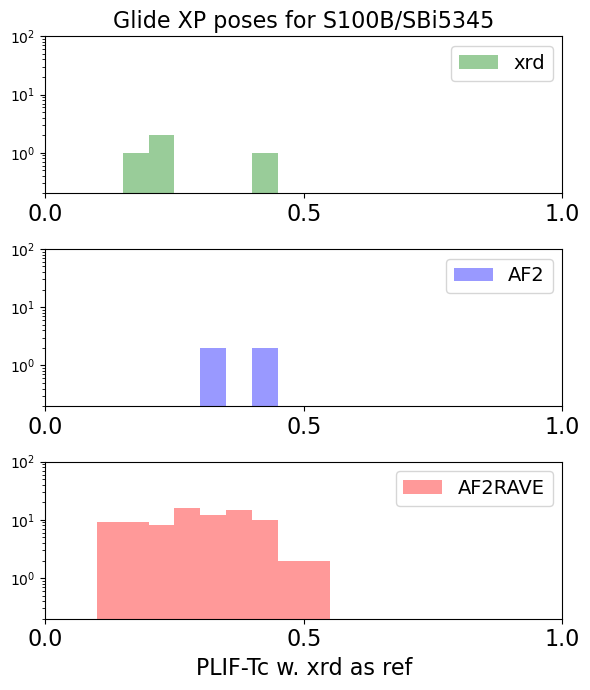

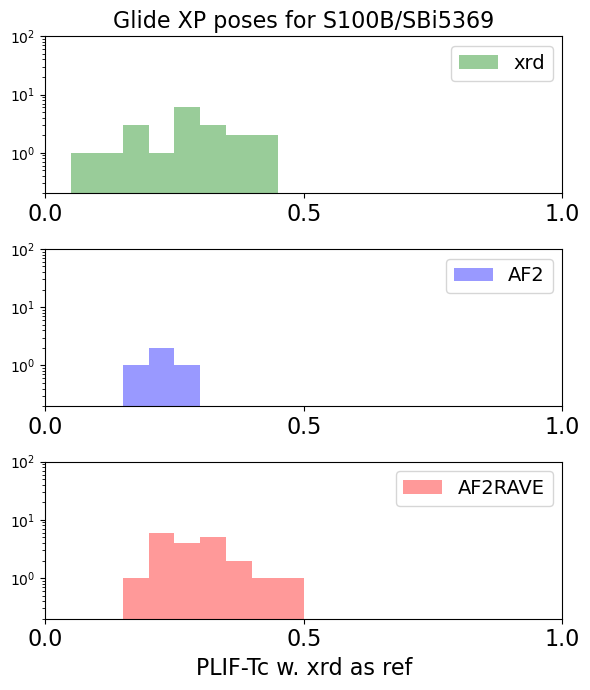

In [67]:
# hist for Tc
temps = ['INH45', 'LIG69']
bin = np.arange(0,1,0.05)
ct = 9
for temp in temps: 
    fig, axs = plt.subplots(3, 1, figsize=(6, 7))
    # xrd
    xrd_files = glob.glob(f'dock_*/SB*csv')
    L_rmsd = []
    for pk, xrd_file in enumerate(xrd_files):        
        match1 = pd.read_csv(f'{xrd_file}', header=0, sep=',') 
        sub1 = match1[(match1['s_m_title'] == temp) & (match1[f'{temp}_l_RMSD'] < ct)]
        L_rmsd.extend(np.max([sub1[f'53{temp[-2:]}_lig1_Tc'].tolist(), sub1[f'53{temp[-2:]}_lig2_Tc'].tolist()], axis=0))      
    axs[0].hist(L_rmsd, color='g', alpha=0.4, bins=bin, label=f'xrd',log=True)
    
    # AF2
    frames = glob.glob('dock_*/AF2_S100B*_match.csv')
    L_rmsd = []
    for pk, frame in enumerate(frames):    
        match1 = pd.read_csv(f'{frame}', header=0, sep=',') 
        sub1 = match1[(match1['s_m_title'] == temp) & (match1[f'{temp}_l_RMSD'] < ct)]
        L_rmsd.extend(np.max([sub1[f'53{temp[-2:]}_lig1_Tc'].tolist(), sub1[f'53{temp[-2:]}_lig2_Tc'].tolist()], axis=0))      
    axs[1].hist(L_rmsd, color='b', alpha=0.4, bins=bin, label=f'AF2',log=True) 
    
    # AF2RAVE
    frames = glob.glob('dock_*/S100B*_match.csv')
    L_rmsd = []
    for pk, frame in enumerate(frames):   
        match1 = pd.read_csv(f'{frame}', header=0, sep=',') 
        sub1 = match1[(match1['s_m_title'] == temp) & (match1[f'{temp}_l_RMSD'] < ct)]
        L_rmsd.extend(np.max([sub1[f'53{temp[-2:]}_lig1_Tc'].tolist(), sub1[f'53{temp[-2:]}_lig2_Tc'].tolist()], axis=0))      
    axs[2].hist(L_rmsd, color='r', alpha=0.4, bins=bin, label=f'AF2RAVE',log=True) 
    
   
    axs[0].set_title(f'Glide XP poses for S100B/SBi53{temp[-2:]}', fontsize=16)
    for ax in axs:
        ax.set_xlim(0, 1)  # Example x limits
        ax.set_ylim(0.2, 100)  # Example y limits
        ax.set_xticks([0, 0.5, 1])
        ax.tick_params(axis='x', labelsize=16)
        ax.legend(fontsize=14,loc='upper right')
    axs[2].set_xlabel(f'PLIF-Tc w. xrd as ref', fontsize=16)
    plt.tight_layout()
    plt.savefig(f"GLide_PLIF_TC_{temp}.png",dpi=300) 

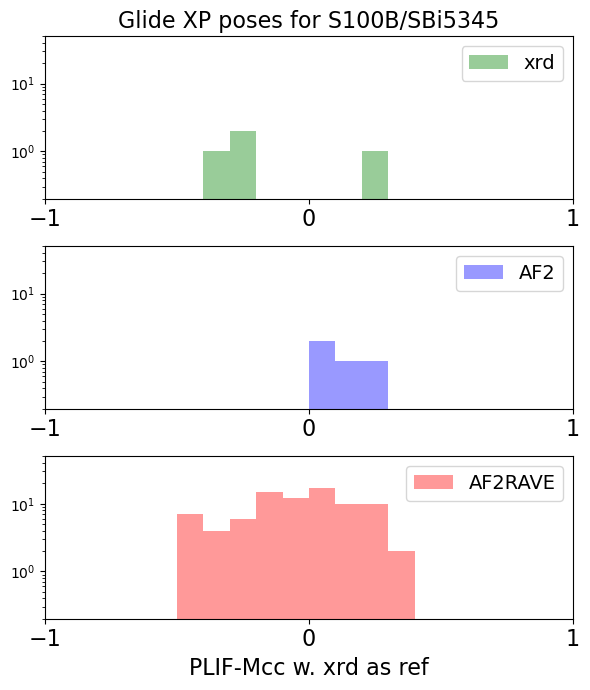

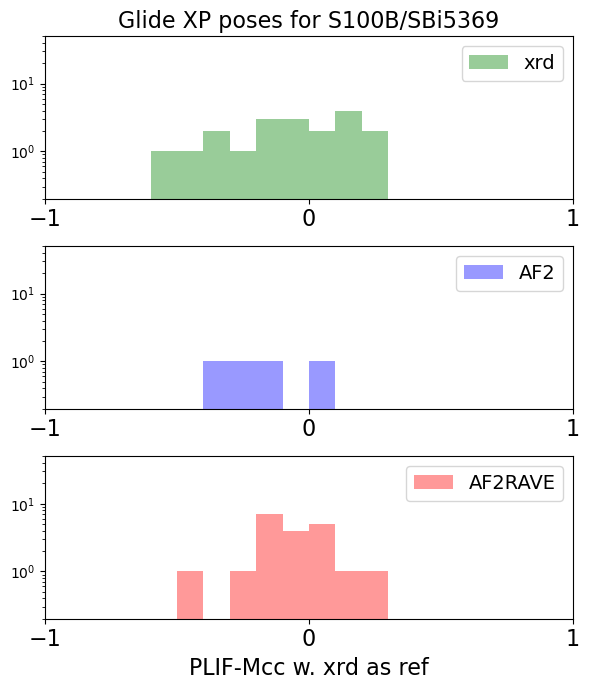

In [73]:
# hist for Mcc
temps = ['INH45', 'LIG69']
bin = np.arange(-1,1,0.1)

for temp in temps: 
    fig, axs = plt.subplots(3, 1, figsize=(6, 7))
    # xrd
    xrd_files = glob.glob(f'dock*/SB*csv')
    L_rmsd = []
    for pk, xrd_file in enumerate(xrd_files):        
        match1 = pd.read_csv(f'{xrd_file}', header=0, sep=',') 
        sub1 = match1[(match1['s_m_title'] == temp) & (match1[f'{temp}_l_RMSD'] < ct)]
        L_rmsd.extend(np.max([sub1[f'53{temp[-2:]}_lig1_Mcc'].tolist(), sub1[f'53{temp[-2:]}_lig2_Mcc'].tolist()], axis=0))      
    axs[0].hist(L_rmsd, color='g', alpha=0.4, bins=bin, label=f'xrd',log=True)
    
    # AF2
    frames = glob.glob('dock*/AF2_S100B*_match.csv')
    L_rmsd = []
    for pk, frame in enumerate(frames):    
        match1 = pd.read_csv(f'{frame}', header=0, sep=',') 
        sub1 = match1[(match1['s_m_title'] == temp) & (match1[f'{temp}_l_RMSD'] < ct)]
        L_rmsd.extend(np.max([sub1[f'53{temp[-2:]}_lig1_Mcc'].tolist(), sub1[f'53{temp[-2:]}_lig2_Mcc'].tolist()], axis=0))      
    axs[1].hist(L_rmsd, color='b', alpha=0.4, bins=bin, label=f'AF2',log=True) 
    
    # AF2RAVE
    frames = glob.glob('dock*/S100B*_match.csv')
    L_rmsd = []
    for pk, frame in enumerate(frames):   
        match1 = pd.read_csv(f'{frame}', header=0, sep=',') 
        sub1 = match1[(match1['s_m_title'] == temp) & (match1[f'{temp}_l_RMSD'] < ct)]
        L_rmsd.extend(np.max([sub1[f'53{temp[-2:]}_lig1_Mcc'].tolist(), sub1[f'53{temp[-2:]}_lig2_Mcc'].tolist()], axis=0))      
    axs[2].hist(L_rmsd, color='r', alpha=0.4, bins=bin, label=f'AF2RAVE',log=True) 
    
   
    axs[0].set_title(f'Glide XP poses for S100B/SBi53{temp[-2:]}', fontsize=16)
    for ax in axs:
        ax.set_xlim(-1, 1)  # Example x limits
        ax.set_ylim(0.2, 50)  # Example y limits
        ax.set_xticks([-1, 0, 1])
        ax.tick_params(axis='x', labelsize=16)
        ax.legend(fontsize=14,loc='upper right')
    axs[2].set_xlabel(f'PLIF-Mcc w. xrd as ref', fontsize=16)
    plt.tight_layout()
    plt.savefig(f"GLide_PLIF_Mcc_{temp}.png",dpi=300) 

(-1.0, 1.0)

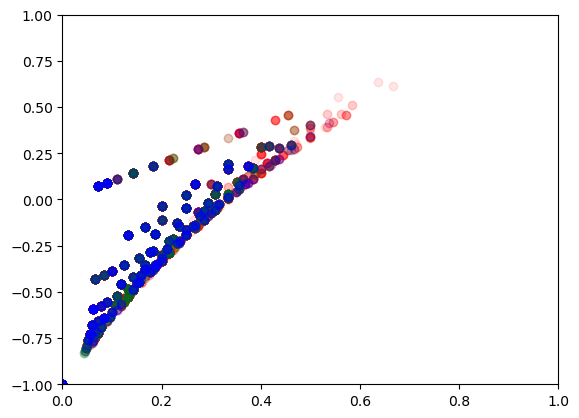

In [43]:
plif_lists = ['5345_lig1', '5345_lig2', '5369_lig1', '5369_lig2']
frames = glob.glob('dock*/S100*_match.csv')
Tc = []
Mcc = []
for pk, frame in enumerate(frames):   
    match1 = pd.read_csv(f'{frame}', header=0, sep=',') 
    for plif in plif_lists:
        Tc.extend(match1[f'{plif}_Tc'].tolist())
        Mcc.extend(match1[f'{plif}_Mcc'].tolist())
plt.scatter(Tc,Mcc,alpha=0.1,color='r')

frames = glob.glob('dock*/SB*_match.csv')
Tc = []
Mcc = []
for pk, frame in enumerate(frames):   
    match1 = pd.read_csv(f'{frame}', header=0, sep=',') 
    for plif in plif_lists:
        Tc.extend(match1[f'{plif}_Tc'].tolist())
        Mcc.extend(match1[f'{plif}_Mcc'].tolist())
plt.scatter(Tc,Mcc,alpha=0.1,color='g')

frames = glob.glob('dock*/AF*_match.csv')
Tc = []
Mcc = []
for pk, frame in enumerate(frames):   
    match1 = pd.read_csv(f'{frame}', header=0, sep=',') 
    for plif in plif_lists:
        Tc.extend(match1[f'{plif}_Tc'].tolist())
        Mcc.extend(match1[f'{plif}_Mcc'].tolist())
plt.scatter(Tc,Mcc,alpha=0.1,color='b')

plt.xlim(0,1)
plt.ylim(-1,1)

In [74]:
frames = glob.glob('dock_*/AF*_match.csv')
for ii, temp in enumerate(temps): 
    for frame in frames:     
        match1 = pd.read_csv(frame, header=0, sep=',') 
        match1['index'] = match1.index
        sub1 = match1[(match1['s_m_title'] == temp) & (match1[f'{temp}_l_RMSD'] < 9)]
        L_rmsd = np.max([sub1[f'53{temp[-2:]}_lig1_Tc'].tolist(), sub1[f'53{temp[-2:]}_lig2_Tc'].tolist()], axis=0)
        if len(L_rmsd) > 0:
            print(f'{frame} {temp}', np.max(L_rmsd), sub1.iloc[np.argmax(L_rmsd)][f'{temp}_l_RMSD'], sub1.iloc[np.argmax(L_rmsd)]['index'])

dock_fine_box/AF2_S100B_ca_A_match.csv INH45 0.4210526315789473 6.417175273451402 0
dock_fine_box/AF2_S100B_ca_B_match.csv LIG69 0.25 7.666252769731231 49


In [71]:
frames = glob.glob('dock_*/SB*_match.csv')
for ii, temp in enumerate(temps): 
    for frame in frames:     
        match1 = pd.read_csv(frame, header=0, sep=',') 
        match1['index'] = match1.index
        sub1 = match1[(match1['s_m_title'] == temp) & (match1[f'{temp}_l_RMSD'] < 9)]
        L_rmsd = np.max([sub1[f'53{temp[-2:]}_lig1_Tc'].tolist(), sub1[f'53{temp[-2:]}_lig2_Tc'].tolist()], axis=0)
        if len(L_rmsd) > 0:
            print(f'{frame} {temp}', np.max(L_rmsd), sub1.iloc[np.argmax(L_rmsd)][f'{temp}_l_RMSD'], sub1.iloc[np.argmax(L_rmsd)]['index'])

dock_fine_box/SB_45_ca_B_match.csv INH45 0.2105263157894736 5.290506706893611 1
dock_fine_box/SB_69_ca_A_match.csv INH45 0.4375 3.067580115450267 4
dock_fine_box/SB_69_ca_B_match.csv INH45 0.2105263157894736 5.728014654516252 0
dock_coarse_box/SB_69_ca_A_match.csv LIG69 0.2941176470588235 4.21455805372702 47
dock_coarse_box/SB_69_ca_B_match.csv LIG69 0.3333333333333333 8.505960536415557 32
dock_fine_box/SB_45_ca_B_match.csv LIG69 0.4166666666666667 8.533031811845118 22
dock_fine_box/SB_69_ca_B_match.csv LIG69 0.3846153846153846 8.259511076067776 27


In [72]:
frames = glob.glob('dock_*/S100B*_match.csv')
for ii, temp in enumerate(temps): 
    for frame in frames:     
        match1 = pd.read_csv(frame, header=0, sep=',') 
        match1['index'] = match1.index
        sub1 = match1[(match1['s_m_title'] == temp) & (match1[f'{temp}_l_RMSD'] < 9)]
        L_rmsd = np.max([sub1[f'53{temp[-2:]}_lig1_Tc'].tolist(), sub1[f'53{temp[-2:]}_lig2_Tc'].tolist()], axis=0)
        if len(L_rmsd) > 0:
            print(f'{frame} {temp}', np.max(L_rmsd), sub1.iloc[np.argmax(L_rmsd)][f'{temp}_l_RMSD'], sub1.iloc[np.argmax(L_rmsd)]['index'])

dock_coarse_box/S100B_b0_0_pLDDT_rank2_ca_B_match.csv INH45 0.3157894736842105 5.593509382819186 19
dock_coarse_box/S100B_b0_1_pLDDT_rank1_ca_A_match.csv INH45 0.2777777777777778 8.890184215872969 32
dock_coarse_box/S100B_b0_1_pLDDT_rank2_ca_B_match.csv INH45 0.1875 7.946754298602226 10
dock_coarse_box/S100B_b0_4_pLDDT_rank1_ca_B_match.csv INH45 0.2631578947368421 4.794305230902473 0
dock_fine_box/S100B_b0_0_pLDDT_rank1_ca_B_match.csv INH45 0.4375 8.635379054318618 14
dock_fine_box/S100B_b0_0_pLDDT_rank2_ca_A_match.csv INH45 0.2777777777777778 8.851198618288494 1
dock_fine_box/S100B_b0_0_pLDDT_rank2_ca_B_match.csv INH45 0.2 8.604434326463965 13
dock_fine_box/S100B_b0_1_pLDDT_rank1_ca_A_match.csv INH45 0.4736842105263157 8.01180759878818 17
dock_fine_box/S100B_b0_1_pLDDT_rank1_ca_B_match.csv INH45 0.3333333333333333 8.409590709538769 20
dock_fine_box/S100B_b0_1_pLDDT_rank2_ca_B_match.csv INH45 0.1764705882352941 7.843850022563575 3
dock_fine_box/S100B_b0_2_pLDDT_rank1_ca_A_match.csv INH

In [61]:
frames = glob.glob('dock_*/S100B*_match.csv')
for ii, temp in enumerate(temps): 
    for frame in frames:     
        match1 = pd.read_csv(frame, header=0, sep=',') 
        match1['index'] = match1.index
        sub1 = match1[match1['s_m_title'] == temp]
        L_rmsd = np.max([sub1[f'53{temp[-2:]}_lig1_Tc'].tolist(), sub1[f'53{temp[-2:]}_lig2_Tc'].tolist()], axis=0)
        print(f'{frame} {temp}', np.max(L_rmsd), sub1.iloc[np.argmax(L_rmsd)]['index'])

dock_coarse_box/S100B_b0_0_pLDDT_rank1_ca_A_match.csv INH45 0.5333333333333333 16
dock_coarse_box/S100B_b0_0_pLDDT_rank1_ca_B_match.csv INH45 0.375 16
dock_coarse_box/S100B_b0_0_pLDDT_rank2_ca_A_match.csv INH45 0.2 4
dock_coarse_box/S100B_b0_0_pLDDT_rank2_ca_B_match.csv INH45 0.3157894736842105 19
dock_coarse_box/S100B_b0_1_pLDDT_rank1_ca_A_match.csv INH45 0.3333333333333333 21
dock_coarse_box/S100B_b0_1_pLDDT_rank1_ca_B_match.csv INH45 0.4375 10
dock_coarse_box/S100B_b0_1_pLDDT_rank2_ca_A_match.csv INH45 0.3125 1
dock_coarse_box/S100B_b0_1_pLDDT_rank2_ca_B_match.csv INH45 0.4285714285714285 24
dock_coarse_box/S100B_b0_2_pLDDT_rank1_ca_A_match.csv INH45 0.4 11
dock_coarse_box/S100B_b0_2_pLDDT_rank1_ca_B_match.csv INH45 0.3571428571428571 2
dock_coarse_box/S100B_b0_2_pLDDT_rank2_ca_A_match.csv INH45 0.3333333333333333 22
dock_coarse_box/S100B_b0_2_pLDDT_rank2_ca_B_match.csv INH45 0.1875 2
dock_coarse_box/S100B_b0_3_pLDDT_rank1_ca_A_match.csv INH45 0.3125 20
dock_coarse_box/S100B_b0_3_pL